# Part 1 - Data Analysing
## Chapter 4 - Sample Weights

In [115]:
import importlib

import numpy as np
import pandas as pd

from utils import general
from utils.bars_generator import create_dollar_bars__rolling
from utils.labels import get_events_triple_barrier, get_vertical_barrier

import matplotlib.pyplot as plt

### 4.1
In Chapter 3, we denoted as t1 a pandas series of timestamps where the first
barrier was touched, and the index was the timestamp of the observation. This
was the output of the getEvents function.

#### 4.1 (a) Compute a t1 series on dollar bars derived from E-mini S&P 500 futures tick data.

In [15]:
btc_dollar = general.load_transactions_and_generate("data\BTCUSDT-trades-2024-*.parquet", create_dollar_bars__rolling, T=int(1e8))

100%|██████████| 5/5 [01:12<00:00, 14.41s/it]


In [97]:
daily_vol = general.get_daily_vol(btc_dollar)

btc_dollar_bar_returns = general.returns(btc_dollar['close'])
t0 = general.get_t_events_dynamic_h(
    btc_dollar.index[1:].values,
    btc_dollar_bar_returns.values,
    daily_vol.index.values,
    daily_vol.values,
    0.1
)

ms_a_day = 24 * 60 * 60 * 1000
num_days = 1
vertical_barrier = get_vertical_barrier(btc_dollar, t0, num_days * ms_a_day)

events = get_events_triple_barrier(close=btc_dollar['close'], t0=t0, tp_scale=1, sl_scale=1,
                                    target=daily_vol, min_return=0.0, t1=vertical_barrier)
print(f'Number of events {len(t0)}.')

Number of events 404.


#### 4.1 (b) Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time.

In [98]:
from utils.sample_weights import num_co_events

co_events = num_co_events(close_idx=btc_dollar.index, t1=events['touch'])

#### 4.1 (c) Plot the time series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis. 

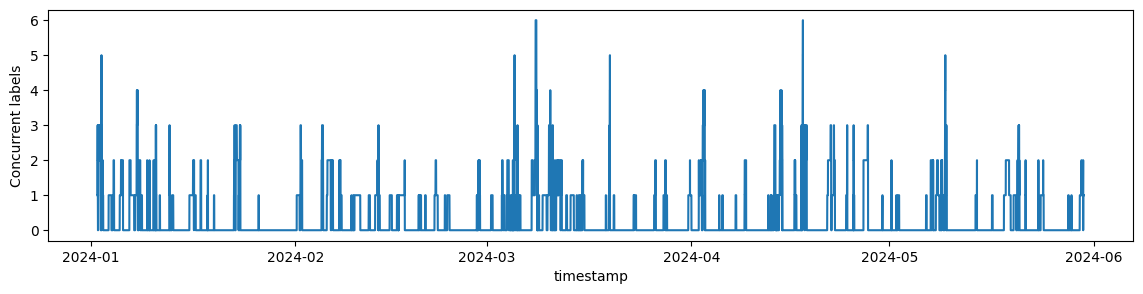

In [99]:
fig, ax = plt.subplots(figsize=(14, 3))
ax.plot(pd.to_datetime(co_events.index, unit='ms'), co_events.values) 
ax.set_xlabel('timestamp')
ax.set_ylabel('Concurrent labels')
ax.tick_params(axis='y')
plt.show()

#### 4.1 (d) Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis). Can you appreciate a relationship?

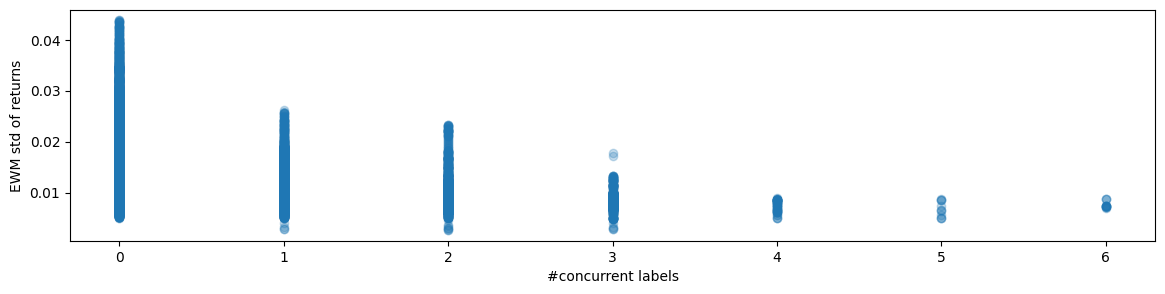

In [100]:
fig, ax = plt.subplots(figsize=(14, 3))
ind = list(set(co_events.index).intersection(set(daily_vol.index)))
ind.sort()
ax.scatter(co_events[ind], daily_vol[ind], alpha=0.25)
ax.set_xlabel('#concurrent labels')
ax.set_ylabel('EWM std of returns')
plt.show()

### 4.2 Using the function mpSampleTW, compute the average uniqueness of each label. What is the first-order serial correlation, AR(1), of this time series? Is it statistically significant? Why?

In [101]:
from statsmodels.tools.sm_exceptions import ValueWarning
import warnings
from scipy.stats import t
from utils.sample_weights import sample_tw
from statsmodels.tsa.ar_model import AutoReg
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels")

avg_uniqueness = sample_tw(events['touch'], co_events)
print('First order auto-correlation:', avg_uniqueness.autocorr(lag=1))

# Fit an AR(1) model
model = AutoReg(avg_uniqueness, lags=1).fit()

# Get the AR(1) coefficient and its standard error
ar1_coefficient = model.params.iloc[1]
std_error = model.bse.iloc[1]

# Calculate the t-statistic
t_statistic = ar1_coefficient / std_error

# Get the p-value
df = len(avg_uniqueness) - 2
p_value = 2 * (1 - t.cdf(abs(t_statistic), df))

print(f"AR(1) Coefficient: {ar1_coefficient}")
print(f"Standard Error: {std_error}")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The first-order serial correlation (AR(1)) is statistically significant (reject H0)")
else:
    print("The first-order serial correlation (AR(1)) is not statistically significant (fail to reject H0)")

First order auto-correlation: 0.5254094739596281
AR(1) Coefficient: 0.5267532645954773
Standard Error: 0.04265128229017676
T-statistic: 12.350232778741018
P-value: 0.0
The first-order serial correlation (AR(1)) is statistically significant (reject H0)


### 4.3 Fit a random forest to a financial dataset where  ∑ū_i / I ≪ 1

In [205]:
t0 = general.get_t_events(
    btc_dollar.index[1:].values,
    btc_dollar_bar_returns.values,
    0.005
)

vertical_barrier = get_vertical_barrier(btc_dollar, t0, num_days * ms_a_day)

events = get_events_triple_barrier(close=btc_dollar['close'], t0=t0, tp_scale=1, sl_scale=1,
                                    target=daily_vol, min_return=0.0, t1=vertical_barrier)

co_events = num_co_events(close_idx=btc_dollar.index, t1=events['touch'])
avg_uniqueness = sample_tw(events['touch'], co_events)
print(f'{avg_uniqueness.sum() / len(avg_uniqueness)} << 1')


0.1146835556366967 << 1


In [206]:
from utils.labels import get_bins
from sklearn.ensemble import RandomForestClassifier
labeled_events = get_bins(events, btc_dollar.close)

X = btc_dollar_bar_returns
X = pd.DataFrame(X.loc[events.index])
y = labeled_events['bin']

rf = RandomForestClassifier(n_estimators=50, oob_score=True)
rf.fit(X, y)
None

#### 4.3 (a) What is the mean out-of-bag accuracy?

In [207]:
print(f'RF OOB accuracy: {rf.oob_score_}')

RF OOB accuracy: 0.5057762304162051


#### 4.3 (b) What is the mean accuracy of k-fold cross-validation (without shuffling) on the same dataset?

In [208]:
from sklearn.model_selection import KFold, cross_val_score


X = pd.DataFrame({
    'return': btc_dollar_bar_returns[events.index],
},
    index=events.index
)
y = labeled_events.bin
kf = KFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(rf, X, y, cv=kf)

# Mean accuracy from k-fold cross-validation
cv_mean_accuracy = np.mean(cv_scores)

print(f'Mean accuracy of k-fold cross-validation {cv_mean_accuracy}.')

Mean accuracy of k-fold cross-validation 0.49738654699980955.


#### 4.3 (c) Why is out-of-bag accuracy so much higher than cross-validation accuracy? Which one is more correct / less biased? What is the source of this bias?

Out-of-bag (OOB) samples are the ones not included in the bootstrap sample used to train each tree. Since OOB accuracy is based on predictions for the data not seen during training of that particular tree, it generally gives a less pessimistic view compared to k-fold cross-validation.

### 4.4 Modify the code in Section 4.7 to apply an exponential time-decay factor

In [212]:
# also found at utils.sample_weights

def exponential_time_decay(tw, exponent=2, clf_last_w=1.):
    clf_w = tw.sort_index()
    clf_w -= clf_w.min()
    clf_w /= clf_w.max()
    clf_w = np.power(clf_w, exponent) / exponent * clf_last_w
    return clf_w

### 4.5 Consider you have applied meta-labels to events determined by a trend-following model. Suppose that two thirds of the labels are 0 and one third of the labels are 1.

#### 4.5 (a) What happens if you fit a classifier without balancing class weights?

The model will have poor results because of 3 reasons:
* Bias toward the majority class
* Poor performance on minority class, while the accuracy metric might look good overall but the classifier may perform poorly on minority class.
* Misleading Metrics, even classifier that always predict 0 will give result of 67% which is more than 50%, so its not totally random but the prediction failed,   

#### 4.5 (b) A label 1 means a true positive, and a label 0 means a false positive. By applying balanced class weights, we are forcing the classifier to pay more attention to the true positives, and less attention to the false positives. Why does that make sense?

Doing so will ensure attention to minority Class and get an equal attention to each label in general even though the data is imbalanced

#### 4.5 (c) What is the distribution of the predicted labels, before and after applying balanced class weights?

Before the balance the prediction distribution will be 67% to be 0's and 33% to be 1s.
After the balance the prediction distribution will be 50% to each class.